[Units](https://colab.research.google.com/drive/12kZELqLgWK4Xdzk2dIGLBgxfBVYrUWNs)

Impulse propagation in a nerve fiber 3 parts - Directed by FitzHugh

https://www.youtube.com/watch?v=lDQ9-PYSEbE

https://www.youtube.com/watch?v=Ae078w44_Bs

https://www.youtube.com/watch?v=PUQBfG9A2Ng


In [ ]:
%%html
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vTw8x8qdqwh8Y1_lyYtAqBcQR9BLqGdaFtW8XPmHMuO8H6B34vaVihnBizgrFQLk8iYPyOpUSl5MIxd/embed?start=false&loop=false&delayms=60000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

[Original Source](https://www.bonaccorso.eu/2017/08/19/hodgkin-huxley-spiking-neuron-model-python/)

The Hodgkin-Huxley model (published on 1952 in The Journal of Physiology [1]) is the most famous spiking neuron model (there are simpler alternatives like the “Integrate-and-fire” model which performs quite well). It’s made up of a system of four ordinary differential equations that can be easily integrated using several different tools. The main idea is based on an electrical representation of the neuron, considering only Potassium (K) and Sodium (Na) voltage-gated ion channels (even if it can be extended to include more channels). A schematic representation is shown in the following figure:

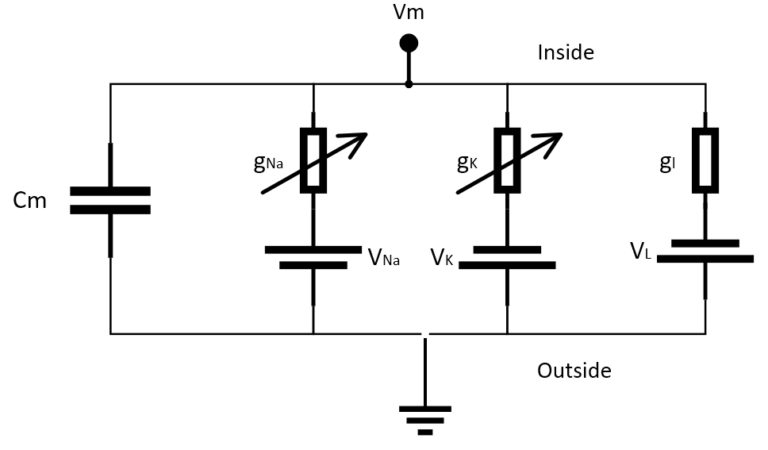

The elements are:

**Cm:** a capacitance per unit area representing the membrane **lipid-bilayer** (adopted value: 1 µF/cm²)


**gNa**: voltage-controlled conductance per unit area associated with the S**odium (Na) ion-channel** (adopted value: 120 µS/cm²)


**gK:** voltage-controlled conductance per unit area associated with the **Potassium (K) ion-channel** (adopted value: 36 µS/cm²)


**gl:** conductance per unit area associated with the **leak channels **(adopted value: 0.3 36 µS/cm²)


**VNa:** voltage source representing the electrochemical **gradient for Sodium **ions (adopted value: 115 mV)


**VK:** voltage source representing the electrochemical **gradient for Potassium** ions (adopted value: -12 mV)


**Vl:** voltage source that determines the **leakage current density **together with gl (adopted value: 10.613 mV)

In the scheme, the external stimulus current is not shown, however, we assume its presence as a current density (I) encoding the input signal. All the experimental values are the same proposed by the authors in [1] and refer to an equilibrium potential of 0 V. The system is defined through the following ODE system:

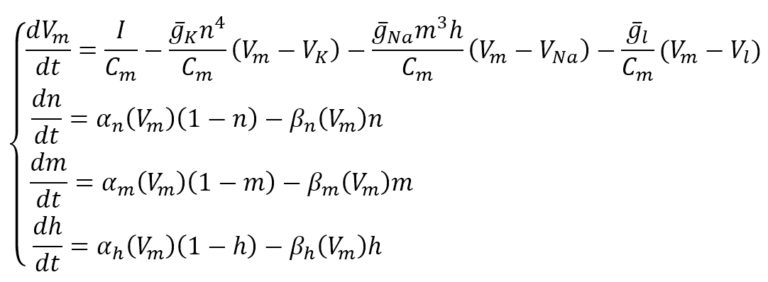

The first equation defines the derivative of Vm considering the external stimulus (I) and the contribution of K, Na, and leakage current densities. 

The variables n, m, and h are associated with the probability of each channel to open and they are strictly dependent on the nature of the channel. 

For example, the K channel is voltage-gated and has four sub-units that must be all open in order to allow the current to flow, therefore its probability is n to the power of 4. 

Sodium has a slightly more complex behavior and needs two different factors (m and h) with autonomous dynamics. 

The last three equations describe the ion-channel kinetic model by computing the derivatives of n, m, and h as functions of the same variables and two voltage-dependent functions. 

The first term is the number of closed channels that are opening, while the second term is the number of open channels that are closing. Hodgkin and Huxley suggest the following functions:

In [ ]:
# Set random seed (for reproducibility)
np.random.seed(1000)

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 50.0

# Time values
T = np.linspace(tmin, tmax, 10000)

In [ ]:
# Average potassium channel conductance per unit area (mS/cm^2)
#gK = 36.0
gK = 0
# Average sodium channel conductance per unit area (mS/cm^2)
gNa = 120.0

# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3

In [ ]:
# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0

# Potassium potential (mV)
VK = -12.0

# Sodium potential (mV)
VNa = 115.0

# Leak potential (mV)
Vl = 10.613

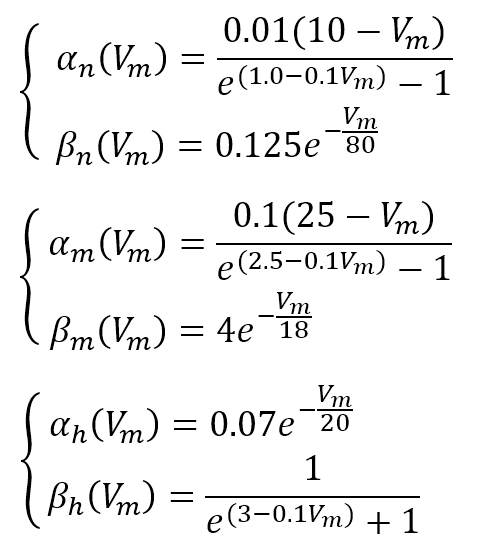

In [ ]:
# Rate functions describe the kinetics of opening & closing of the channels as a function of the membrane potential

# Potassium ion-channel rate functions

def alpha_n(Vm):  #opening rate
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm): #closing rate
    return 0.125 * np.exp(-Vm / 80.0)


# Sodium ion-channel rate functions

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)


# Leak channel rate functions

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)


In [ ]:
# For the plot, from - to + 100, to the 1000th place (check this description)
x = np.linspace(-100,100,1000)

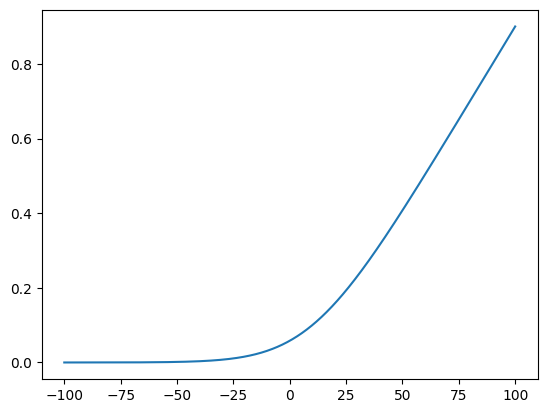

In [ ]:
# potassium membrane potential
y = alpha_n(x) 
plt.plot(x,y)

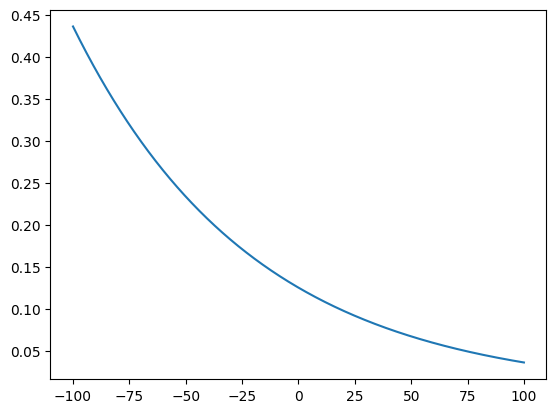

In [ ]:
# K
y = beta_n(x)
plt.plot(x,y)

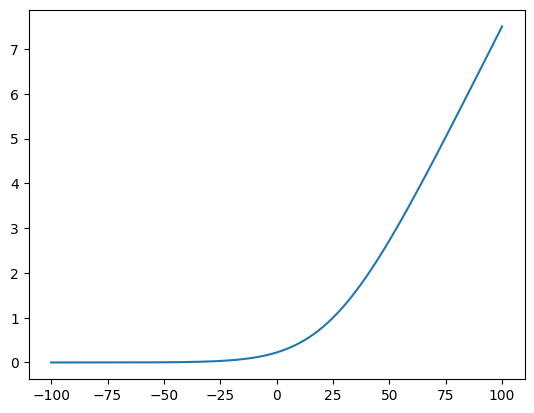

In [ ]:
# sodium
y = alpha_m(x)
plt.plot(x,y)

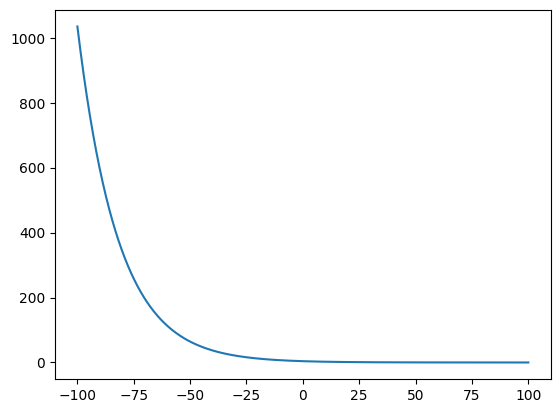

In [ ]:
# Na
y = beta_m(x)
plt.plot(x,y)

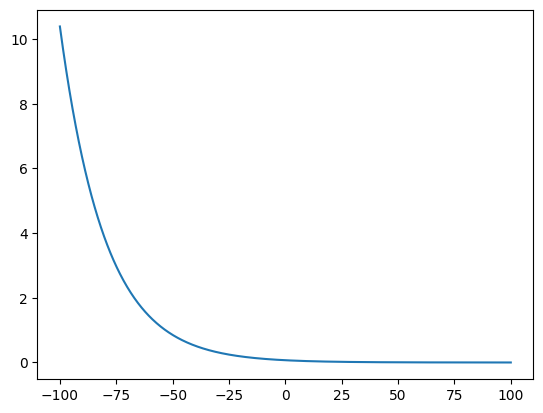

In [ ]:
# Leak
y = alpha_h(x)
plt.plot(x,y)

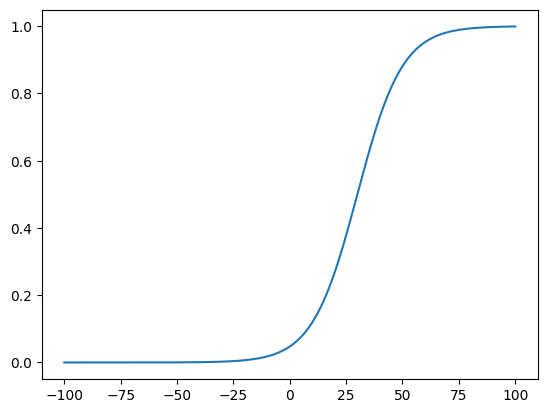

In [ ]:
# leak
y = beta_h(x)
plt.plot(x,y)

In [ ]:
# Compute derivatives (calculated using Ohm's law and the conductances of the ion channels)
def compute_derivatives(y, t0):
    
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

In [ ]:
# This function represents an external current stimulus applied to the neuron
# stimulus is 0 except for 1s where the stimulus is 150
def Id(t):
    if 10.0 < t < 11.0:
        return 150.0
    # elif 20.0 < t < 21.0:
    #     return 5.0
    return 0.0

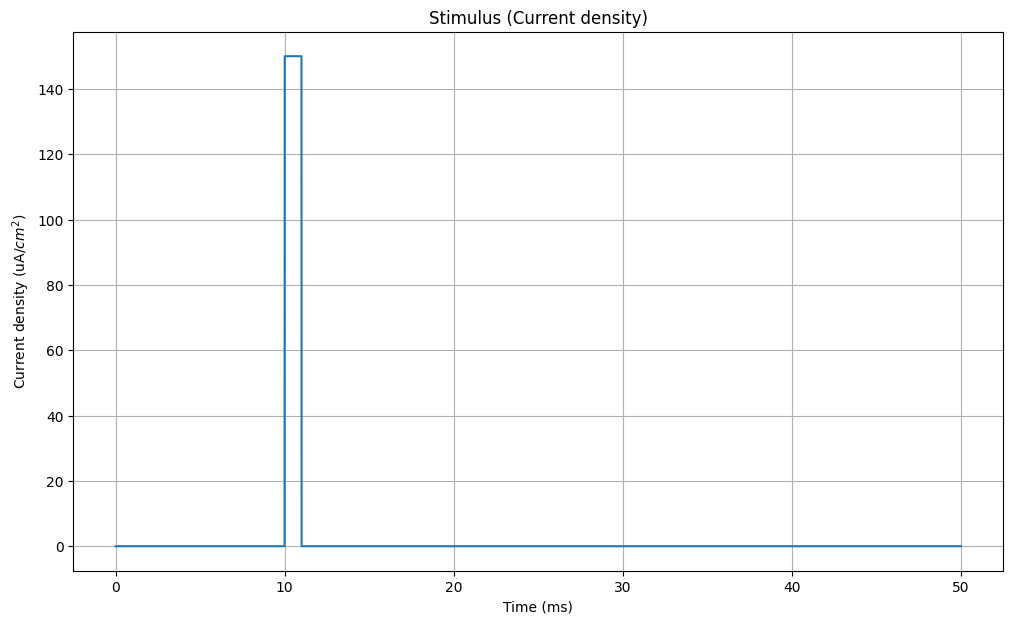

In [ ]:
# Input stimulus
Idv = [Id(t) for t in T]

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, Idv)
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Current density (uA/$cm^2$)')
ax.set_title('Stimulus (Current density)')
plt.grid()

In [ ]:
# n, m, and h steady-state values using the rate functions 
# used to check if the gating variables have reached their steady-state during simulation

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

In [ ]:
n_inf(),m_inf(),h_inf()

(0.3176769140606974, 0.05293248525724958, 0.5961207535084603)

In [ ]:
# State (Vm, n, m, h)
X = np.array([0.0, 0.31, 0.05, 0.59]) 

In [ ]:
# Solve ODE system
# V represents the time evolution of the membrane potential and teh gating variables
# according to the dynamics defined by the ODE system
V = odeint(compute_derivatives, X, T)

The resulting impulsive neuron behavior is shown in the following plot:

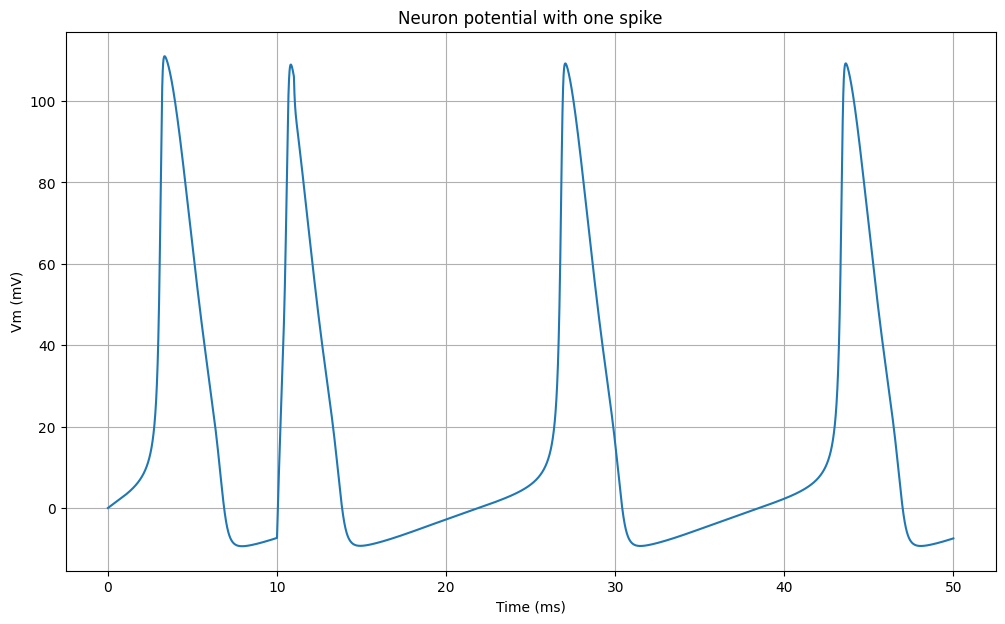

In [ ]:
# Neuron potential
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(T, V[:, 0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neuron potential with one spike')
plt.grid()

It’s also possible to observe the limit cycles present in the dynamic system. In the following plot, the trajectories Vm – n, and Vm – m are plotted:

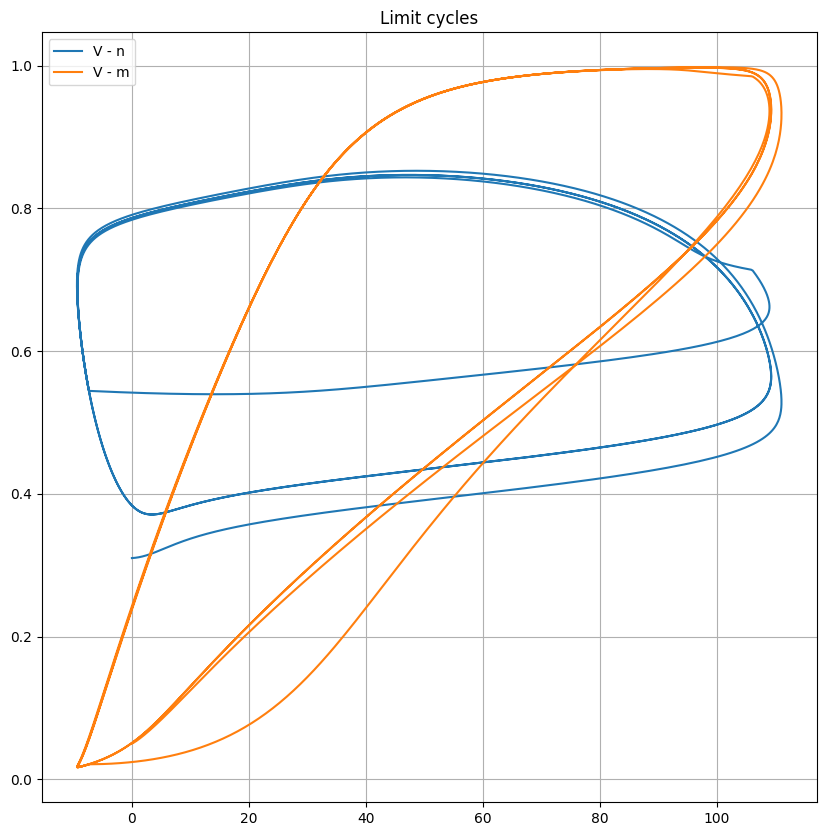

In [ ]:
# Trajectories with limit cycles
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(V[:, 0], V[:, 1], label='V - n')
ax.plot(V[:, 0], V[:, 2], label='V - m')
ax.set_title('Limit cycles')
ax.legend()
plt.grid()

References:

[1] Hodgkin, A. L., Huxley, A. F., (1952), A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117 doi: 10.1113/jphysiol.1952.sp004764


[2] Abbott L. F., Dayan P., Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems, The MIT Press